# 🤖 Riskrover

This document explains the riskrover machine learning pipeline designed to predict European soccer match outcomes, leveraging data from the European Soccer Database on Kaggle and aiming for an edge against bookmakers. The core logic resides in `pipeline.py`, which defines the preprocessing steps and model architecture using scikit-learn, complemented by feature definitions in `features.json`.

In [ ]:
import os
import json

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from dotenv import load_dotenv
from databricks import sql

# from risk

load_dotenv()

True

## 💾 Loading dataset

We're reading the dataset from databricks, for this we fetch environment variables.

<div style="background-color: #e6e6fa;
    border-left: 6px solid #7c3aed;
    font-color: black;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
    🛠️ <b>TODO</b> Also write a preprocessing pipeline which works locally (for example duckdb), such that we can run the example not only when a Databricks cluster is available.
</div>


In [ ]:
connection = sql.connect(
    server_hostname=os.environ["DATABRICKS_HOST"],
    http_path=os.environ["DATABRICKS_HTTP_PATH"],
    access_token=os.environ["DATABRICKS_TOKEN"],
)

dataset = "football_datasets"
cursor = connection.cursor()
cursor.execute(f"select * from {dataset}.match_dataset order by match_date")

df_match = pd.DataFrame(cursor.fetchall(), columns=[x[0] for x in cursor.description])
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20510 entries, 0 to 20509
Columns: 422 entries, id to season_progress
dtypes: float64(85), int64(7), object(330)
memory usage: 66.0+ MB


## 🤖 Riskrover model

Easy to initialize

In [ ]:
from riskrover.model import RiskRover

risk_rover = RiskRover()

### ✂️ Train test split

To split the dataset in order to correctly train the ML model such that it can be used in real life scenario (no train / serve skew), we need to split in time, hold out data contains football matches after max training date

In [ ]:
from riskrover.pipeline import preprocess_match_dataset
from datetime import timedelta

# this gives us 1 season of test / evaluation data
train_end_date = "2015-07-01"
test_end_date = "2015-12-31"

X_train, y_train = preprocess_match_dataset(df_match, max_date=train_end_date)

# Convert train_end_date to datetime, add 1 day, then format back to string
test_start_date = (pd.to_datetime(train_end_date) + timedelta(days=1)).strftime(
    "%Y-%m-%d"
)
X_test, y_test = preprocess_match_dataset(
    df_match, min_date=test_start_date, max_date=test_end_date
)

X_train.head()

,league_name,odds_b365h,odds_b365d,odds_b365a,odds_bwh,odds_bwd,odds_bwa,odds_iwh,odds_iwd,odds_iwa,...,away_defencepressure,home_defenceaggression,away_defenceaggression,home_defenceteamwidth,away_defenceteamwidth,home_team_form_5m,away_team_form_5m,home_points_per_match,away_points_per_match,season_progress
id,,,,,,,,,,,,,,,,,,,,,
22055,Spain LIGA BBVA,1.57,4.0,5.50,1.50,3.80,6.50,1.55,3.7,6.00,...,40.0,60.0,30.0,60.0,50.0,NaN,NaN,NaN,NaN,0.605263
17979,Portugal Liga ZON Sagres,3.00,3.0,2.50,2.55,2.95,2.70,2.50,3.0,2.70,...,30.0,30.0,30.0,30.0,30.0,NaN,NaN,NaN,NaN,0.666667
2312,England Premier League,1.20,6.5,15.00,1.20,6.00,12.00,1.20,5.5,14.00,...,30.0,50.0,70.0,40.0,30.0,NaN,NaN,NaN,NaN,0.736842
424,Belgium Jupiler League,3.75,3.4,1.91,3.75,3.40,1.85,3.90,3.3,1.75,...,70.0,70.0,65.0,70.0,70.0,NaN,NaN,NaN,NaN,0.800000
10718,Italy Serie A,2.90,3.1,2.50,2.90,3.20,2.35,2.85,3.2,2.40,...,30.0,30.0,35.0,60.0,60.0,NaN,NaN,NaN,NaN,0.447368


<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
    ℹ️ <strong>Some stuff to note about the dataset</strong>
    <ul>
        <li>all rows are already sorted on match_date => helps us with Time split cross validation</li>
        <li>Without feature selection => close to <b>400</b> features, watch out for the curse of Dimensionality</li>
        <li>The processed features in <code>X_train</code> correspond to the pipeline branches described in the section below (<a href="#🧠-pipeline">Pipeline</a>): categorical, numeric, odds, and other stats</li>
        <li>We've held out some test / evaluation data to test our bookmaker's scores by only training to <code>train_end_date</code></li>
    </ul>
</div>

### ⭐️ Features

In the packaging of this ML model, we blueprint our features in a resource file (JSON).

In [ ]:
import importlib.resources

with importlib.resources.files("riskrover").joinpath("features.json").open() as f:
    features = json.load(f)

features.keys()

dict_keys(['season_info', 'odds', 'numeric_stats', 'categorical_stats', 'other_stats', 'all'])

<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
Each dictionary key defines how to process the feature from the match_dataset within the pipeline
</div>

Features are organized into the following logical groups:

- **season_info**: Contains league_name, representing the league in which the match is played.
- **odds**: A comprehensive list of pre-match betting odds from various bookmakers (e.g., b365h, b365d, b365a for Bet365 Home, Draw, Away odds). These are crucial for understanding market sentiment and identifying value.
- **numeric_stats**: This is a very extensive list of numerical statistics, predominantly derived from player attributes (i.e. fifa). It includes **aggregated (average, median, min, max, count) player statistics** for both home (home_) and away (away_) teams, covering attributes like:
    - age
    - height
    - weight
    - overall_rating
    - potential
    - FIFA game attributes:
        - crossing
        - finishing
        - heading_accuracy
        - short_passing
        - volleys
        - dribbling
        - curve
        - free_kick_accuracy
        - long_passing
        - ball_control
        - acceleration
        - sprint_speed
        - agility
        - reactions
        - balance
        - shot_power
        - jumping
        - stamina
        - strength
        - long_shots
        - aggression
        - interceptions
        - positioning
        - vision
        - penalties
        - marking
        - standing_tackle
        - sliding_tackle
    - GK attributes:
        - gk_diving
        - gk_handling
        - gk_kicking
        - gk_positioning
        - gk_reflexes
    - Player work rates and preferred foot counts
- **categorical_stats**: These features represent tactical playing styles of teams, These are typically ordinal categorical variables indicating preferences (e.g., "Slow", "Normal", "Fast"). such as:
    - buildupplaydribblingclass
    - buildupplayspeedclass
    - chancecreationpassingclass, etc. 
- **other_stats**: A mixed bag of *continuous features* related to team tactics that are not classified as `CategoricalDtype`, such as 
    - home_buildupplaydribbling (likely a numerical rating associated with the categorical class)
    - team form metrics (home_team_form_5m)
    - points per match
    - season_progress (a temporal feature).

### 🧠 Pipeline

The `riskrover.pipeline` module orchestrates the entire data processing and modeling workflow. It defines how raw input data is transformed, cleaned, and prepared before being fed into a predictive model.

In [ ]:
from sklearn import set_config

set_config(display="diagram")
# set_config(display="text")
risk_rover.pipeline

,steps,"[('type_split', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categories', ...), ('stats', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


Let's breakdown this pipeline!

#### `type_split`: Main preprocessing router

<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
This acts as the central router of the unprocessed match data, directing different sets of features to their appropriate mini-pipelines.
</div>

##### `categorical_pipeline`

<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
Handles categorical features and season information.
</div>


In [ ]:
cols = risk_rover.pipeline.named_steps["type_split"].transformers[0][2]
X_train.loc[:, cols].head()

,league_name,home_buildupplaydribblingclass,away_buildupplaydribblingclass,home_buildupplayspeedclass,away_buildupplayspeedclass,home_buildupplaypassingclass,away_buildupplaypassingclass,home_buildupplaypositioningclass,away_buildupplaypositioningclass,home_chancecreationpassingclass,...,home_chancecreationpositioningclass,away_chancecreationpositioningclass,home_defencepressureclass,away_defencepressureclass,home_defenceaggressionclass,away_defenceaggressionclass,home_defenceteamwidthclass,away_defenceteamwidthclass,home_defencedefenderlineclass,away_defencedefenderlineclass
id,,,,,,,,,,,,,,,,,,,,,
22055,Spain LIGA BBVA,Little,Little,Slow,Slow,Short,Mixed,Free Form,Organised,Normal,...,Organised,Free Form,Medium,Medium,Press,Contain,Normal,Normal,Offside Trap,Offside Trap
17979,Portugal Liga ZON Sagres,Little,Little,Slow,Slow,Short,Short,Organised,Organised,Normal,...,Organised,Organised,Deep,Deep,Contain,Contain,Narrow,Narrow,Offside Trap,Offside Trap
2312,England Premier League,Little,Little,Fast,Balanced,Mixed,Short,Organised,Organised,Normal,...,Free Form,Organised,Medium,Deep,Press,Double,Normal,Narrow,Cover,Cover
424,Belgium Jupiler League,Little,Little,Balanced,Balanced,Mixed,Mixed,Organised,Organised,Normal,...,Organised,Organised,Medium,High,Double,Press,Wide,Wide,Cover,Cover
10718,Italy Serie A,Little,Little,Fast,Balanced,Short,Short,Free Form,Free Form,Normal,...,Free Form,Free Form,Medium,Deep,Contain,Press,Normal,Normal,Offside Trap,Offside Trap


In [ ]:
categorical_tf = risk_rover.pipeline.named_steps["type_split"].transformers[0][1]
categorical_tf.fit_transform(X_train.loc[:, cols]).head()

/Users/dori/Documents/dataroots/your-best-bet/.venv/lib/python3.12/site-packages/riskrover/transformers.py:94: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(mode_map)


,home_buildupplaydribblingclass,away_buildupplaydribblingclass,home_buildupplayspeedclass,away_buildupplayspeedclass,home_buildupplaypassingclass,away_buildupplaypassingclass,home_buildupplaypositioningclass,away_buildupplaypositioningclass,home_chancecreationpassingclass,away_chancecreationpassingclass,...,away_chancecreationpositioningclass,home_defencepressureclass,away_defencepressureclass,home_defenceaggressionclass,away_defenceaggressionclass,home_defenceteamwidthclass,away_defenceteamwidthclass,home_defencedefenderlineclass,away_defencedefenderlineclass,league_name
id,,,,,,,,,,,,,,,,,,,,,
22055,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,-1.0,0.0,0.0,1.0,1.0,0.8
17979,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,0.4
2312,-1.0,-1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,...,-1.0,0.0,-1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-0.8
424,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,-1.0,0.0,1.0,0.0,1.0,1.0,1.0,-1.0,-1.0,-1.0
10718,-1.0,-1.0,1.0,0.0,-1.0,-1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,-1.0,-1.0,1.0,0.0,0.0,1.0,1.0,-0.2



- `GroupedImputer`: A custom transformer that **imputes missing values based on groups** (e.g., `league_name`, since often the league statistic is a better heuristic than globally). It uses **the mode** (most common value) for imputation.
- `SimpleImputer(strategy="most_frequent")`: A **fallback imputer** to catch any remaining missing categorical values.
- `encode_split`: Split up the ordinal encoding between player attributes and 
    - `ordinal_encoder`: Applies `preprocessing.OrdinalEncoder` to the categorical_stats (e.g., buildupplaydribblingclass). ⚠️ Crucially, it uses `categories=[CATEGORICAL_TYPES[c].categories.tolist() ...]` to ensure the defined order from `pd.CategoricalDtype` is respected during encoding.
    - `league_encoder`: Applies zpreprocessing.OrdinalEncoder to league_name, where the order doesn't matter
- `MinMaxScaler(feature_range=(-1, 1))`: Scales the encoded categorical features to a fixed range. This can be beneficial for models sensitive to feature scales.

##### `stats` pipeline
<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
Processes numerical player and team statistics.</div>


In [ ]:
cols = risk_rover.pipeline.named_steps["type_split"].transformers[1][2]
X_train[cols].tail()

,home_avg_age,away_avg_age,home_avg_height,away_avg_height,home_avg_weight,away_avg_weight,home_median_age,away_median_age,home_median_height,away_median_height,...,away_defencepressure,home_defenceaggression,away_defenceaggression,home_defenceteamwidth,away_defenceteamwidth,home_team_form_5m,away_team_form_5m,home_points_per_match,away_points_per_match,season_progress
id,,,,,,,,,,,,,,,,,,,,,
12832,25.636364,29.909091,184,181,172,166,24.0,30.0,185,183,...,54.0,57.0,66.0,64.0,46.0,5.0,2.0,1.486486,0.675676,1.0
12828,27.363636,26.636364,185,181,177,168,28.0,27.0,185,178,...,23.0,47.0,47.0,36.0,53.0,10.0,12.0,1.243243,1.594595,1.0
12825,29.363636,28.181818,183,181,169,165,30.0,28.0,183,183,...,39.0,34.0,49.0,52.0,57.0,4.0,1.0,1.378378,0.648649,1.0
12833,25.181818,25.909091,183,183,170,168,25.0,25.0,183,183,...,40.0,56.0,46.0,51.0,57.0,7.0,3.0,0.837838,1.108108,1.0
12826,28.727273,30.454545,182,186,169,179,28.0,30.0,183,188,...,46.0,59.0,59.0,67.0,51.0,12.0,6.0,1.648649,1.162162,1.0


In [ ]:
stats_tf = risk_rover.pipeline.named_steps["type_split"].transformers[1][1]
stats_tf.fit_transform(X_train.loc[:, cols]).tail()

,home_avg_age,away_avg_age,home_avg_height,away_avg_height,home_avg_weight,away_avg_weight,home_median_age,away_median_age,home_median_height,away_median_height,...,away_defencepressure,home_defenceaggression,away_defenceaggression,home_defenceteamwidth,away_defenceteamwidth,home_team_form_5m,away_team_form_5m,home_points_per_match,away_points_per_match,season_progress
id,,,,,,,,,,,,,,,,,,,,,
12832,-0.607810,1.955387,1.012859,-0.562239,0.493281,-0.754129,-1.173423,1.750247,1.110984,0.319560,...,0.724775,0.748739,1.650983,1.195718,-0.671963,-0.488872,-1.461317,0.238385,-1.228366,1.598043
12828,0.437700,-0.018839,1.544926,-0.562239,1.545404,-0.335626,0.787136,0.283626,1.110984,-1.662722,...,-2.290027,-0.247631,-0.244900,-1.709245,0.054082,1.005769,1.513881,-0.187651,0.371522,1.598043
12825,1.648290,0.913434,0.480792,-0.562239,-0.137993,-0.963380,1.767415,0.772500,0.311405,0.319560,...,-0.734000,-1.542913,-0.045333,-0.049266,0.468964,-0.787801,-1.758837,0.049036,-1.275421,1.598043
12833,-0.882944,-0.457556,0.480792,0.494993,0.072431,-0.335626,-0.683283,-0.694122,0.311405,0.319560,...,-0.636748,0.649102,-0.344683,-0.153015,0.468964,0.108984,-1.163797,-0.897712,-0.475477,1.598043
12826,1.263102,2.284424,-0.051275,2.080842,-0.137993,1.966141,0.787136,1.750247,0.311405,2.301842,...,-0.053238,0.948013,0.952500,1.506964,-0.153360,1.603626,-0.271238,0.522410,-0.381366,1.598043



- `SimpleImputer(strategy="median")`: Imputes missing numerical values with the **median**, which is **robust to outliers**.
- `StandardScaler()`: Standardizes numerical features by removing the mean and scaling to unit variance.


##### `odds` pipeline 
<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
Processes betting odds features.</div>

In [ ]:
cols = risk_rover.pipeline.named_steps["type_split"].transformers[2][2]
X_train[cols].head()

,odds_b365h,odds_b365d,odds_b365a,odds_bwh,odds_bwd,odds_bwa,odds_iwh,odds_iwd,odds_iwa,odds_lbh,...,odds_sja,odds_vch,odds_vcd,odds_vca,odds_gbh,odds_gbd,odds_gba,odds_bsh,odds_bsd,odds_bsa
id,,,,,,,,,,,,,,,,,,,,,
22055,1.57,4.0,5.50,1.50,3.80,6.50,1.55,3.7,6.00,1.50,...,7.00,1.53,3.75,6.5,1.55,3.75,6.00,1.53,4.00,6.00
17979,3.00,3.0,2.50,2.55,2.95,2.70,2.50,3.0,2.70,2.50,...,2.75,2.75,3.00,2.5,2.60,3.00,2.60,2.60,2.88,2.60
2312,1.20,6.5,15.00,1.20,6.00,12.00,1.20,5.5,14.00,1.17,...,15.00,1.20,6.50,17.0,1.20,6.00,13.00,1.20,6.00,15.00
424,3.75,3.4,1.91,3.75,3.40,1.85,3.90,3.3,1.75,4.00,...,1.91,4.33,3.20,1.8,4.00,3.40,1.80,3.80,3.30,1.83
10718,2.90,3.1,2.50,2.90,3.20,2.35,2.85,3.2,2.40,2.60,...,2.60,2.88,3.00,2.5,2.90,3.10,2.45,2.75,3.20,2.50


In [ ]:
X_train[cols].isna().sum()

odds_b365h    2299
odds_b365d    2299
odds_b365a    2299
odds_bwh      2313
odds_bwd      2313
odds_bwa      2313
odds_iwh      2355
odds_iwd      2355
odds_iwa      2355
odds_lbh      2330
odds_lbd      2330
odds_lba      2330
odds_psh      8914
odds_psd      8914
odds_psa      8914
odds_whh      2308
odds_whd      2308
odds_wha      2308
odds_sjh      4887
odds_sjd      4887
odds_sja      4887
odds_vch      2317
odds_vcd      2317
odds_vca      2317
odds_gbh      7821
odds_gbd      7821
odds_gba      7821
odds_bsh      7821
odds_bsd      7821
odds_bsa      7821
dtype: int64

In [ ]:
odds_tf = risk_rover.pipeline.named_steps["type_split"].transformers[2][1]
odds_tf.fit_transform(X_train.loc[:, cols]).head()

/Users/dori/Documents/dataroots/your-best-bet/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,odds_b365h,odds_b365d,odds_b365a,odds_bwh,odds_bwd,odds_bwa,odds_iwh,odds_iwd,odds_iwa,odds_lbh,...,odds_sja,odds_vch,odds_vcd,odds_vca,odds_gbh,odds_gbd,odds_gba,odds_bsh,odds_bsd,odds_bsa
id,,,,,,,,,,,,,,,,,,,,,
22055,-0.584197,0.104522,0.213138,-0.637836,0.002532,0.609722,-0.626371,0.075172,0.630718,-0.630537,...,0.624164,-0.588426,-0.177665,0.332424,-0.617236,0.044896,0.507102,-0.627753,0.285736,0.462414
17979,0.193193,-0.763102,-0.573229,-0.017186,-0.794797,-0.513412,0.011918,-0.769039,-0.504715,-0.037274,...,-0.496153,0.013880,-0.756591,-0.545390,0.046446,-0.751144,-0.566257,0.042138,-0.897374,-0.553644
2312,-0.785340,2.273581,2.703299,-0.815164,2.066207,2.235312,-0.861530,2.245999,3.383285,-0.826314,...,2.732996,-0.751345,1.945064,2.636686,-0.838463,2.433015,2.716959,-0.834356,2.398433,3.151979
424,0.600915,-0.416053,-0.727881,0.692127,-0.372682,-0.764640,0.952556,-0.407234,-0.831583,0.852621,...,-0.717581,0.793916,-0.602211,-0.699008,0.931355,-0.326589,-0.818812,0.793419,-0.453707,-0.783751
10718,0.138830,-0.676340,-0.573229,0.189697,-0.560288,-0.616859,0.247078,-0.527836,-0.607937,0.022053,...,-0.535694,0.078060,-0.756591,-0.545390,0.236070,-0.645005,-0.613611,0.136048,-0.559342,-0.583528


In [ ]:
assert odds_tf.fit_transform(X_train.loc[:, cols]).isna().sum().sum() == 0

/Users/dori/Documents/dataroots/your-best-bet/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(




- `StandardScaler()`: Standardizes odds.
- IterativeImputer(...): Uses an advanced iterative imputation strategy (MICE by default with sklearn) to fill in missing odds values. This method models each feature with missing values as a function of other features, providing more accurate imputations than simple strategies. n_nearest_features=5 means it uses the 5 nearest features to impute a missing value. skip_complete=True means features with no missing values are not imputed.

<div style="background-color: #fff3e0;
    border-left: 6px solid #ff9800;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
    ⚠️ The <code>IterativeImputer</code> is an experimental feature for sklearn. The reasoning behind using something so sophisticated for the odds is clear, it should enhance the prediction power, and we can safely make the hypothesis that odds at a certain bookmaker are a decent proxy to the odds at another.
</div>


#### Feature Selection
<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
Selects the top k features based on the F-value calculated for classification tasks. This helps reduce dimensionality and potentially improve model performance and generalization.
</div>

<div style="background-color: #fff3e0;
    border-left: 6px solid #ff9800;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
    ⚠️ This applies a univariate statistical test on each feature
</div>

In [ ]:
col_tf = risk_rover.pipeline.named_steps["type_split"]
x_fs_in = col_tf.fit_transform(X_train)
x_fs_in.head()

/Users/dori/Documents/dataroots/your-best-bet/.venv/lib/python3.12/site-packages/riskrover/transformers.py:94: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(mode_map)
/Users/dori/Documents/dataroots/your-best-bet/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,home_buildupplaydribblingclass,away_buildupplaydribblingclass,home_buildupplayspeedclass,away_buildupplayspeedclass,home_buildupplaypassingclass,away_buildupplaypassingclass,home_buildupplaypositioningclass,away_buildupplaypositioningclass,home_chancecreationpassingclass,away_chancecreationpassingclass,...,odds_sja,odds_vch,odds_vcd,odds_vca,odds_gbh,odds_gbd,odds_gba,odds_bsh,odds_bsd,odds_bsa
id,,,,,,,,,,,,,,,,,,,,,
22055,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,...,0.624164,-0.588426,-0.177665,0.332424,-0.617236,0.044896,0.507102,-0.627753,0.285736,0.462414
17979,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,...,-0.496153,0.013880,-0.756591,-0.545390,0.046446,-0.751144,-0.566257,0.042138,-0.897374,-0.553644
2312,-1.0,-1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,0.0,-1.0,...,2.732996,-0.751345,1.945064,2.636686,-0.838463,2.433015,2.716959,-0.834356,2.398433,3.151979
424,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,-0.717581,0.793916,-0.602211,-0.699008,0.931355,-0.326589,-0.818812,0.793419,-0.453707,-0.783751
10718,-1.0,-1.0,1.0,0.0,-1.0,-1.0,1.0,1.0,0.0,0.0,...,-0.535694,0.078060,-0.756591,-0.545390,0.236070,-0.645005,-0.613611,0.136048,-0.559342,-0.583528


In [ ]:
fs_tf = risk_rover.pipeline.named_steps["selector"]
fs_tf.set_params(k=100)

x_fs_out = fs_tf.fit_transform(x_fs_in, y=y_train)
x_fs_out.head()

,home_avg_overall_rating,away_avg_overall_rating,home_median_overall_rating,away_median_overall_rating,home_max_overall_rating,away_max_overall_rating,home_avg_potential,away_avg_potential,home_median_potential,away_median_potential,...,odds_sja,odds_vch,odds_vcd,odds_vca,odds_gbh,odds_gbd,odds_gba,odds_bsh,odds_bsd,odds_bsa
id,,,,,,,,,,,,,,,,,,,,,
22055,0.030483,0.184309,0.156479,0.147997,-0.004257,-0.009154,0.02821,0.024346,0.037125,0.033899,...,0.624164,-0.588426,-0.177665,0.332424,-0.617236,0.044896,0.507102,-0.627753,0.285736,0.462414
17979,0.030483,0.184309,0.156479,0.147997,-0.004257,-0.009154,0.02821,0.024346,0.037125,0.033899,...,-0.496153,0.013880,-0.756591,-0.545390,0.046446,-0.751144,-0.566257,0.042138,-0.897374,-0.553644
2312,0.030483,0.184309,0.156479,0.147997,-0.004257,-0.009154,0.02821,0.024346,0.037125,0.033899,...,2.732996,-0.751345,1.945064,2.636686,-0.838463,2.433015,2.716959,-0.834356,2.398433,3.151979
424,0.030483,0.184309,0.156479,0.147997,-0.004257,-0.009154,0.02821,0.024346,0.037125,0.033899,...,-0.717581,0.793916,-0.602211,-0.699008,0.931355,-0.326589,-0.818812,0.793419,-0.453707,-0.783751
10718,0.030483,0.184309,0.156479,0.147997,-0.004257,-0.009154,0.02821,0.024346,0.037125,0.033899,...,-0.535694,0.078060,-0.756591,-0.545390,0.236070,-0.645005,-0.613611,0.136048,-0.559342,-0.583528





#### Modeling

- `model`: Which Supervised Learning model to use => you should be able to predict **probabilities** to model bookmaker beatings. The default is `LogisticRegression` but you can customise.
- Calibration: forces calibrated probabilities

<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
    ℹ️ Calibration is a critical step, especially for applications like beating bookmakers. 
    <p>It calibrates the predicted probabilities of the base model. Bookmakers are beaten by finding mispriced bets, which requires <strong>accurate probability estimates</strong>, not just accurate class predictions.
    </p>

</div>

In [ ]:
calibrator = risk_rover.pipeline.named_steps["model"]
# calibrator.set_params(method="isotonic")
# below avoids a ConvergenceWarning (not converged yet)
calibrator.estimator.set_params(max_iter=1000)


calibrator.fit(x_fs_out, y_train)

,estimator,LogisticRegre...max_iter=1000)
,method,'sigmoid'
,cv,None
,n_jobs,None
,ensemble,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1


In [ ]:
calibrator.predict_proba(x_fs_out)

array([[0.53994371, 0.26781098, 0.19224531],
       [0.38548895, 0.27974687, 0.33476417],
       [0.70554069, 0.22351094, 0.07094838],
       ...,
       [0.68150399, 0.22232947, 0.09616654],
       [0.40558387, 0.25899946, 0.33541667],
       [0.63897984, 0.23002911, 0.13099105]], shape=(17184, 3))

### 🚝 Training

 
by calling `.fit()` on your data. The <a href="#🧠-pipeline">Pipeline</a> above was built with a Logistic Regression and that's a nice default as we will see (since it's optimized to predicting probabilities). However the `build_pipeline` method accepts any model that fits the [scikit-learn estimator API](https://scikit-learn.org/stable/developers/develop.html).

In [ ]:
from sklearn.linear_model import LogisticRegression

algorithm = RiskRover(
    model=LogisticRegression(
        penalty="l2",
        C=1.0,
        max_iter=1000,
        random_state=42,
    ),
    verbose=True,
)

In [ ]:
%%time
algorithm.pipeline.fit(X_train, y_train)

/Users/dori/Documents/dataroots/your-best-bet/.venv/lib/python3.12/site-packages/riskrover/transformers.py:94: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(mode_map)
/Users/dori/Documents/dataroots/your-best-bet/.venv/lib/python3.12/site-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[Pipeline] ........ (step 1 of 3) Processing type_split, total=   3.3s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=   0.4s
CPU times: user 3.2 s, sys: 310 ms, total: 3.51 s
Wall time: 3.81 s


,steps,"[('type_split', ...), ('selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,True
,transformers,"[('categories', ...), ('stats', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### 🎲 Inference: Value betting

`Riskrover` implements the `__call__` function and tells us what to bet on. 

RiskRover takes a DataFrame of matches (with bookmaker odds as columns) and, for each row, predicts the probability of each outcome (home, draw, away) using its trained model. It then **converts these probabilities into "model odds" (1/probability)**, and compares them to the best available bookmaker odds for each outcome.
<div style="background-color: #e6ffe6; border-left: 6px solid #34c759; padding: 16px; border-radius: 6px; margin: 10px 0;">
<b>💡 How does inference work?</b>
For each match:
    <ol>
        <li>It finds the highest bookmaker odd for each outcome (across all bookies).</li>
        <li>It computes the model's implied odds for each outcome.</li>
        <li>It calculates the expected profit for each outcome as:<br>
            <b>expected_profit = (bookmaker_odd / model_odd) - 1</b>
        </li>
        <li>If the expected profit is positive, the model believes the bookmaker has mispriced the odds in our favor.</li>
        <li>The model selects the outcome with the highest expected profit as the recommended bet.</li>
    </ol>
</div>

The returned DataFrame contains, for each match, the recommended bet, the odds taken, the model's odds, the expected profit, and a flag (`xYieldsProfit`) indicating if the bet is expected to be profitable.

**Mathematical logic:**

- Let $p_{model}$ be the model's predicted probability for an outcome.
- Let $o_{bookie}$ be the best bookmaker odd for that outcome.
- The model's fair odd is $o_{model} = \frac{1}{p_{model}}$, i.e. implied probability from the bookmaker: $p_bookie = \frac{1}{odd_bookie}$.
- The expected profit is $\frac{o_{bookie}}{o_{model}} - 1 $ (*assuming we bet 1 unit*).
- If expected profit > 0, the bet is considered "value", and we make the bet!

This approach is known as **"value betting"—betting only** when your estimated probability implies the odds are in your favor.

In [ ]:
%%time
bets_train = algorithm(X_train)
bets_train.head()

CPU times: user 37.5 s, sys: 496 ms, total: 38 s
Wall time: 40.2 s


,bet,xOdd,bookie,odd_bookie,xProfit,xYieldsProfit,decision_info,xHome,xAway,xDraw
id,,,,,,,,,,
22055,away,4.179260,odds_sja,7.0,2.820740,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",1.682659,4.179260,6.008688
17979,draw,2.776689,odds_lbd,3.1,0.323311,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",2.829227,3.491555,2.776689
2312,away,6.570073,odds_vca,17.0,10.429927,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",1.245238,6.570073,22.353610
424,draw,2.151850,odds_b365d,3.4,1.248150,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",3.572809,3.915553,2.151850
10718,draw,2.651625,odds_bwd,3.2,0.548375,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",3.016087,3.432683,2.651625


Here’s a concise description of each column in the table:

- **id**: Unique identifier for the match or prediction row.
- **bet**: The recommended bet outcome ("home", "away", or "draw") with the highest expected profit.
- **xOdd**: The model’s implied fair odds for the recommended bet (calculated as 1 / predicted probability).
- **bookie**: The bookmaker column name offering the best odds for the recommended bet.
- **odd_bookie**: The best available bookmaker odds for the recommended bet.
- **xProfit**: Expected profit for the recommended bet, calculated as (odd_bookie / xOdd) - 1.
- **xYieldsProfit**: Boolean indicating if the expected profit is positive (True = value bet).
- **decision_info**: JSON with detailed info for all outcomes (home, away, draw): model odds, best bookmaker odds, expected profit, and value bet flag for each.
- **xHome**: Model’s implied fair odds for the home win.
- **xAway**: Model’s implied fair odds for the away win.
- **xDraw**: Model’s implied fair odds for a draw.

<div style=" background-color: #e6e6fa;
    border-left: 6px solid #7c3aed;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
<strong>🛠️ Applying the decision row to row on a pandas dataframe is slow</strong>
Here we could write a better implementation
</div>

<div style=" background-color: #fffde7;
    border-left: 6px solid #fbbc05;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
    <strong>💡 Betting strategy</strong>
    <p>Now we can decide on a betting strategy to maximize gains. Here are some ideas:
        <ul>
            <li>Only bet when <code>xYieldsProfit=True</code>, speaks for itself</li>
            <li>Only bet when <code>xProfit > threshold</code>, this means we prioritize betting on the most promising odds</li>
            <li>Dynamic betting => adapt the value of the bet based on <code>xProfit</code></li>
        </ul>
    </p>
</div>

<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
    ℹ️ For now, let's stick to an easy strategy: <b>Value of bet = 1 if xYieldsProfit = True</b>
</div>

Let's make our bets on the test set!

In [ ]:
from riskrover.pipeline import TARGET_MAP


def value_bet_strategy(row):
    return 1 if row["xProfit"] > 0 else 0


def make_bet(df_odds, stake_function=value_bet_strategy):
    """assign a stake to each bet based on the stake_function, adds stake and y_bet columns to df_odds"""
    return df_odds.assign(
        stake=lambda x: df_odds.apply(stake_function, axis=1),
        y_bet=lambda x: x["bet"].map(TARGET_MAP),
    )


df_bets_test = algorithm(X_test).pipe(make_bet)
df_bets_test.sample(5, random_state=2)

,bet,xOdd,bookie,odd_bookie,xProfit,xYieldsProfit,decision_info,xHome,xAway,xDraw,stake,y_bet
id,,,,,,,,,,,,
25834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.120899,3.860463,3.711050,0,NaN
19679,home,2.326621,odds_iwh,2.30,-0.026621,False,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",2.326621,3.732897,3.307933,0,0.0
12911,home,2.312215,odds_psh,2.32,0.007785,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",2.312215,3.652931,3.404122,1,0.0
9958,away,3.649548,odds_psa,4.08,0.430452,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",2.144286,3.649548,3.851518,1,2.0
7487,draw,3.228841,odds_vcd,3.40,0.171159,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",2.433693,3.579186,3.228841,1,1.0


<div style="background-color: #fff3e0;
    border-left: 6px solid #ff9800;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
⚠️ Sometimes we cannot place a bet, since we don't have the bookie odds in our dataset, henca we cannot find the value and make money.
</div>

## 🤑 Profit simulation + analysis

In [ ]:
from riskrover.pipeline import TARGET_MAP


def evaluate(df_odds, y_true, match_dataset=None):
    df_simulation = (
        df_odds.copy().dropna(subset=["bet"])
        # first include the outcome
        .assign(
            y_true=y_true,
        )
        # calculate profit
        .assign(
            profit=lambda x: x["stake"]
            * (
                (x["odd_bookie"] - 1) * (x["y_bet"] == x["y_true"]).astype(int)
                - (x["y_bet"] != x["y_true"]).astype(int)
            )
        )
        # calculate cumulative profit and win/loss
        .assign(
            cumulative_profit=lambda x: x["profit"].cumsum(),
            win=lambda x: x["profit"] > 0,
        )
    )

    if match_dataset is not None:
        df_simulation = (
            df_simulation.join(match_dataset[["id", "match_date"]].set_index("id"))
            .assign(match_date=lambda x: pd.to_datetime(x["match_date"]))
            .sort_values(by="match_date")
            .reset_index(drop=True)
        )

    return df_simulation

In [ ]:
df_bets_sim = evaluate(
    df_bets_test,
    y_test,
    match_dataset=df_match,
)

df_bets_sim.head()

,bet,xOdd,bookie,odd_bookie,xProfit,xYieldsProfit,decision_info,xHome,xAway,xDraw,stake,y_bet,y_true,profit,cumulative_profit,win,match_date
0,draw,2.097600,odds_psd,4.09,1.992400,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",3.795331,3.849365,2.097600,1,1.0,0,-1.0,-1.0,False,2015-07-24
1,away,4.027530,odds_lba,6.00,1.972470,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",1.770624,4.027530,5.349415,1,2.0,0,-1.0,-2.0,False,2015-07-25
2,draw,3.061741,odds_psd,3.34,0.278259,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",2.498962,3.660024,3.061741,1,1.0,0,-1.0,-3.0,False,2015-07-25
3,draw,2.939243,odds_psd,3.42,0.480757,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",2.520455,3.801956,2.939243,1,1.0,0,-1.0,-4.0,False,2015-07-25
4,draw,3.287763,odds_psd,3.47,0.182237,True,"{""bet"":{""0"":""home"",""1"":""away"",""2"":""draw""},""xOd...",2.357407,3.681248,3.287763,1,1.0,0,-1.0,-5.0,False,2015-07-25


### 📈 Cumulative profit over time

<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
ℹ️ <b>This is the most important chart for any investment or betting strategy. </b>
<p>It shows the overall performance and trajectory of your bankroll.</p>
</div>

In [ ]:
def profit_over_time(df, add_break_even=True, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    label = "Cumulative Profit"
    if "label" in kwargs:
        label = kwargs["label"]
        del kwargs["label"]

    sns.lineplot(
        data=df,
        x="match_date",
        y="cumulative_profit",
        marker="o",
        label=label,
        ax=ax,
        **kwargs
    )
    if add_break_even:
        ax.axhline(0, color="red", linestyle="--", label="Break-even Point")
    ax.set_title("Cumulative Profit Over Time", fontsize=16)
    ax.set_xlabel("Match Date")
    ax.set_ylabel("Cumulative Profit (in units)")
    ax.legend()
    ax.tick_params(axis="x", rotation=45)

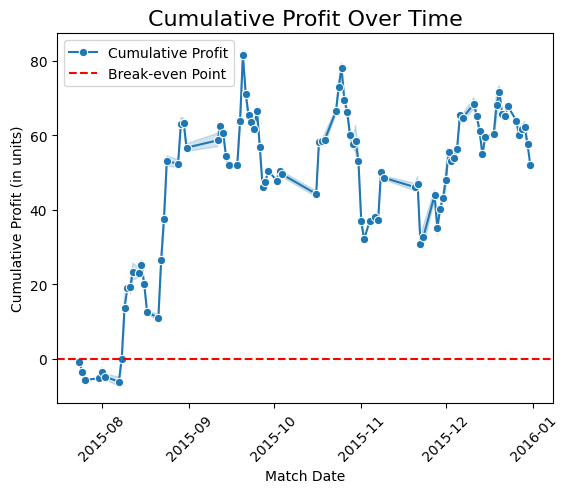

In [ ]:
profit_over_time(df_bets_sim)

<div style="background-color: #e6f4ea;
    border-left: 6px solid #34a853;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
    💰 KASSA
</div>

### ⚖️ Balance checkout

In [ ]:
def evaluate_betting_strategy(dataframe: pd.DataFrame):
    """
    Calculates and prints a comprehensive performance report for a betting strategy.

    Args:
        dataframe (pd.DataFrame): DataFrame containing betting history with columns:
                                 'profit', 'stake', 'cumulative_profit', 'win',
                                 'odd_bookie'.
    """
    if dataframe.empty:
        print("The DataFrame is empty. No stats to calculate.")
        return

    # Basic Metrics
    total_bets = len(dataframe)
    total_staked = dataframe["stake"].sum()
    total_profit = dataframe["profit"].sum()

    # Performance Metrics
    roi_yield = (total_profit / total_staked) * 100 if total_staked > 0 else 0
    num_winning_bets = dataframe["win"].sum()
    win_rate = (num_winning_bets / total_bets) * 100 if total_bets > 0 else 0

    # Hit rate (y_bet matches y_true)
    hit_rate = (
        (dataframe["y_bet"] == dataframe["y_true"]).sum() / total_bets * 100
        if total_bets > 0
        else 0
    )

    # Odds Analysis
    avg_odds_taken = dataframe["odd_bookie"].mean()
    avg_winning_odd = (
        dataframe[dataframe["win"]]["odd_bookie"].mean() if num_winning_bets > 0 else 0
    )
    avg_losing_odd = (
        dataframe[~dataframe["win"]]["odd_bookie"].mean()
        if total_bets > num_winning_bets
        else 0
    )

    # Risk Metric: Maximum Drawdown
    # The largest peak-to-trough decline in cumulative profit.
    running_max = dataframe["cumulative_profit"].cummax()
    drawdown = running_max - dataframe["cumulative_profit"]
    max_drawdown = drawdown.max()

    # --- Print Report ---
    print("=" * 40)
    print("   Betting Strategy Performance Report")
    print("=" * 40)
    print(
        f" Time Period: {dataframe['match_date'].min().date()} to {dataframe['match_date'].max().date()}"
    )
    print("-" * 40)
    print("Overall Performance:")
    print(f"  - Total Bets Placed:    {total_bets}")
    print(f"  - Total Units Staked:   {total_staked:.2f}")
    print(f"  - Total Profit / Loss:  {total_profit:+.2f} units")
    print(f"  - ROI (Yield):          {roi_yield:+.2f}%")
    print("-" * 40)
    print("Consistency & Accuracy:")
    print(
        f"  - Win Rate (profitable):{win_rate:.2f}% ({num_winning_bets}/{total_bets} bets)"
    )
    print(f"  - Hit Rate (correct):   {hit_rate:.2f}% (correct outcome predicted)")
    print("-" * 40)
    print("Odds Analysis:")
    print(f"  - Average Odd Taken:    {avg_odds_taken:.2f}")
    print(f"  - Average Winning Odd:  {avg_winning_odd:.2f}")
    print(f"  - Average Losing Odd:   {avg_losing_odd:.2f}")
    print("-" * 40)
    print("Risk Analysis:")
    print(f"  - Maximum Drawdown:     {max_drawdown:.2f} units")
    print("=" * 40)


evaluate_betting_strategy(df_bets_sim)

   Betting Strategy Performance Report
 Time Period: 2015-07-24 to 2015-12-31
----------------------------------------
Overall Performance:
  - Total Bets Placed:    1438
  - Total Units Staked:   1411.00
  - Total Profit / Loss:  +51.89 units
  - ROI (Yield):          +3.68%
----------------------------------------
Consistency & Accuracy:
  - Win Rate (profitable):24.06% (346/1438 bets)
  - Hit Rate (correct):   24.76% (correct outcome predicted)
----------------------------------------
Odds Analysis:
  - Average Odd Taken:    5.61
  - Average Winning Odd:  4.23
  - Average Losing Odd:   6.05
----------------------------------------
Risk Analysis:
  - Maximum Drawdown:     63.13 units


### Selected Odds and "xOdd"

Which model odds are the most interesting? Is there any section with extra value?

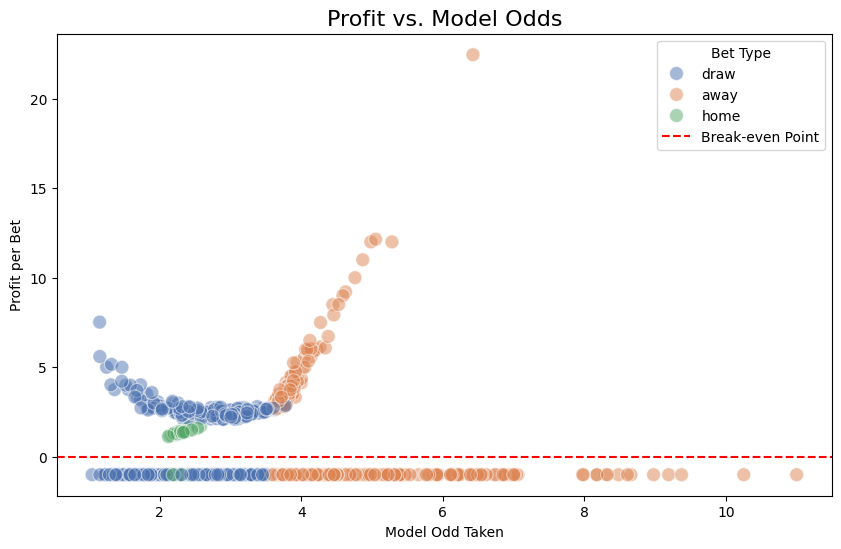

In [ ]:
def profit_vs_model_odds(df, ax=None):
    if ax is None:
        ax = plt.gca()

    df = df[df.stake > 0]  # Filter out rows with no stake

    sns.scatterplot(
        data=df,
        x="xOdd",
        y="profit",
        hue="bet",
        s=100,
        palette="deep",
        ax=ax,
        alpha=0.5,
    )
    ax.axhline(0, color="red", linestyle="--", label="Break-even Point")
    ax.set_title("Profit vs. Model Odds", fontsize=16)
    ax.set_xlabel("Model Odd Taken")
    ax.set_ylabel("Profit per Bet")
    ax.legend(title="Bet Type")


plt.figure(figsize=(10, 6))
profit_vs_model_odds(df_bets_sim)

## ❎ Cross Validation

In order to find the best parameters for the models and store experiments.

For a Random Forest the hyperparameters are harder to finetune, so let's perform the cross validation for a random forest, and try a new betting strategy and compare with the Logistic Regression!

In [ ]:
import scipy
from sklearn import ensemble, linear_model


def build_param_grid(model_name):
    """
    Build parameter grid for grid search based on the selected model.

    Args:
    - model_name (str): Name of the machine learning model.

    Returns:
    - dict: Parameter grid for grid search.
    """
    model_params = {
        f"model__estimator__{k}": v for k, v in _MODEL_GRIDS[model_name].items()
    }
    return {**model_params, **_PIPELINE_PARAMS}


def get_model(model_name):
    """
    Get the instance of the selected machine learning model.

    Args:
    - model_name (str): Name of the machine learning model.

    Returns:
    - object: Instance of the specified machine learning model.
    """
    match model_name:
        case "random_forest":
            return ensemble.RandomForestClassifier()
        case "logistic_regression":
            return linear_model.LogisticRegression(max_iter=1000)


_MODEL_GRIDS = {
    "random_forest": {
        "n_estimators": scipy.stats.randint(50, 1000),
        "max_depth": scipy.stats.randint(5, 25),
        "criterion": ["gini", "entropy", "log_loss"],
        "min_samples_split": scipy.stats.randint(2, 10),
    },
    "logistic_regression": {
        "C": scipy.stats.loguniform(0.1, 1000),
    },
}

# Parameters for the pipeline
_PIPELINE_PARAMS = {
    "selector__k": scipy.stats.randint(20, 100),
}

# Scoring metrics for cross-validation, best model will be selected based on 'neg_log_loss'
_CV_SCORING = [
    "neg_log_loss",
    "accuracy",
    "f1_macro",
    "precision_macro",
    "recall_macro",
    "roc_auc_ovr",
]

In [ ]:
from riskrover.pipeline import build_pipeline
from sklearn import model_selection

n_iter = 10

algorithm = get_model("random_forest")
clf = build_pipeline(algorithm, verbose=True)
cv = model_selection.RandomizedSearchCV(
    estimator=clf,
    param_distributions=build_param_grid("random_forest"),
    n_iter=n_iter,
    scoring=_CV_SCORING,
    n_jobs=-1,
    refit="neg_log_loss",
    # gap asserts the test split is starting on a different date
    cv=model_selection.TimeSeriesSplit(n_splits=2, gap=50).split(X_train),
    return_train_score=True,
    verbose=3,
)

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
cv.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[Pipeline] ........ (step 1 of 3) Processing type_split, total=   1.5s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.0s
[Pipeline] ........ (step 1 of 3) Processing type_split, total=   2.2s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.1s
[Pipeline] ........ (step 1 of 3) Processing type_split, total=   1.3s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.0s
[Pipeline] ........ (step 1 of 3) Processing type_split, total=   2.6s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.1s
[Pipeline] ........ (step 1 of 3) Processing type_split, total=   1.6s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.0s
[Pipeline] ........ (step 1 of 3) Processing type_split, total=   2.7s
[Pipeline] .......... (step 2 of 3) Processing selector, total=   0.1s
[Pipeline] ............. (step 3 of 3) Processing model, total=  27.3s
[Pipeline] .....

,estimator,Pipeline(step... verbose=True)
,param_distributions,"{'model__estimator__criterion': ['gini', 'entropy', ...], 'model__estimator__max_depth': <scipy.stats....t 0x335b001d0>, 'model__estimator__min_samples_split': <scipy.stats....t 0x335d89790>, 'model__estimator__n_estimators': <scipy.stats....t 0x11fd33860>, ...}"
,n_iter,10
,scoring,"['neg_log_loss', 'accuracy', ...]"
,n_jobs,-1
,refit,'neg_log_loss'
,cv,<generator ob...t 0x335c9f4c0>
,verbose,3
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


### 👀 Evaluation

Let's make predictions and compare with the Logistic Regression above.

In [ ]:
rf_rover = RiskRover(pipeline=cv.best_estimator_, verbose=True)
rf_bets = rf_rover(X_test).pipe(make_bet)

rf_bets_sim = evaluate(
    rf_bets,
    y_test,
    match_dataset=df_match,
)

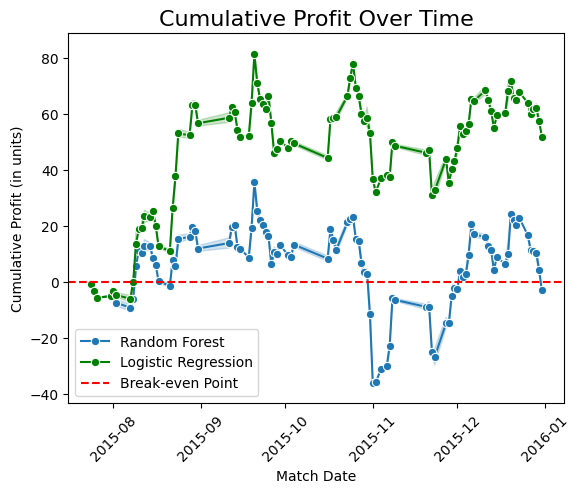

In [ ]:
ax = profit_over_time(rf_bets_sim, label="Random Forest", add_break_even=False)
profit_over_time(df_bets_sim, ax=ax, color="green", label="Logistic Regression")

In [ ]:
evaluate_betting_strategy(rf_bets_sim)

   Betting Strategy Performance Report
 Time Period: 2015-07-24 to 2015-12-31
----------------------------------------
Overall Performance:
  - Total Bets Placed:    1438
  - Total Units Staked:   1431.00
  - Total Profit / Loss:  -3.16 units
  - ROI (Yield):          -0.22%
----------------------------------------
Consistency & Accuracy:
  - Win Rate (profitable):23.50% (338/1438 bets)
  - Hit Rate (correct):   23.64% (correct outcome predicted)
----------------------------------------
Odds Analysis:
  - Average Odd Taken:    5.74
  - Average Winning Odd:  4.22
  - Average Losing Odd:   6.21
----------------------------------------
Risk Analysis:
  - Maximum Drawdown:     86.53 units


<div style="background-color: #e8f0fe;
    border-left: 6px solid #4285f4;
    padding: 16px;
    border-radius: 6px;
    margin: 10px 0;">
 ℹ️ In this simulation, Logistic Regression wins. This shouldn't surprise too much since it better captivate probabilities in its model, which isotonic calibration might not fix within the Random Forest. However, this is definitely due to some noise and other simulations might yield different results. You can analyze this yourself 😊
</div>